In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Maximum Likelihood Estimates for the Skew-Normal Distribution

In class, we showed an example of calculating the maximum likelihood estimates for the two parameters $\mu$ and $\sigma^2$ of the univariate normal distribution. We actually had a **closed-form solution**

$$\hat \mu_\text{MLE} = \frac{1}{n} \sum_{i=1}^n x_i,$$
$$\hat \sigma^2_\text{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \mu_\text{MLE})^2 $$

These are pretty much what we'd guess the formulas would be by looking at the definition of mean and variance.

In this exercise, we'll examine a distribution in which calculating the MLE estimates of the parameters have no closed-form solution -- that is, we cannot use calculus to optimize the likelihood function exactly. In this case, we have to rely on **numerical optimization** techniques to find high-likelihood parameters.

The problem we'll work with is fitting a distribution to a sample of normalized nanoparticle radii
$$ R / \langle R \rangle$$ 
where $\langle R \rangle$ is an average value of the nanoparticle radius. 

We'll first load our data file which contains samples of normalized nanoparticle radii, then plot the distribution

Text(0, 0.5, 'Frequency')

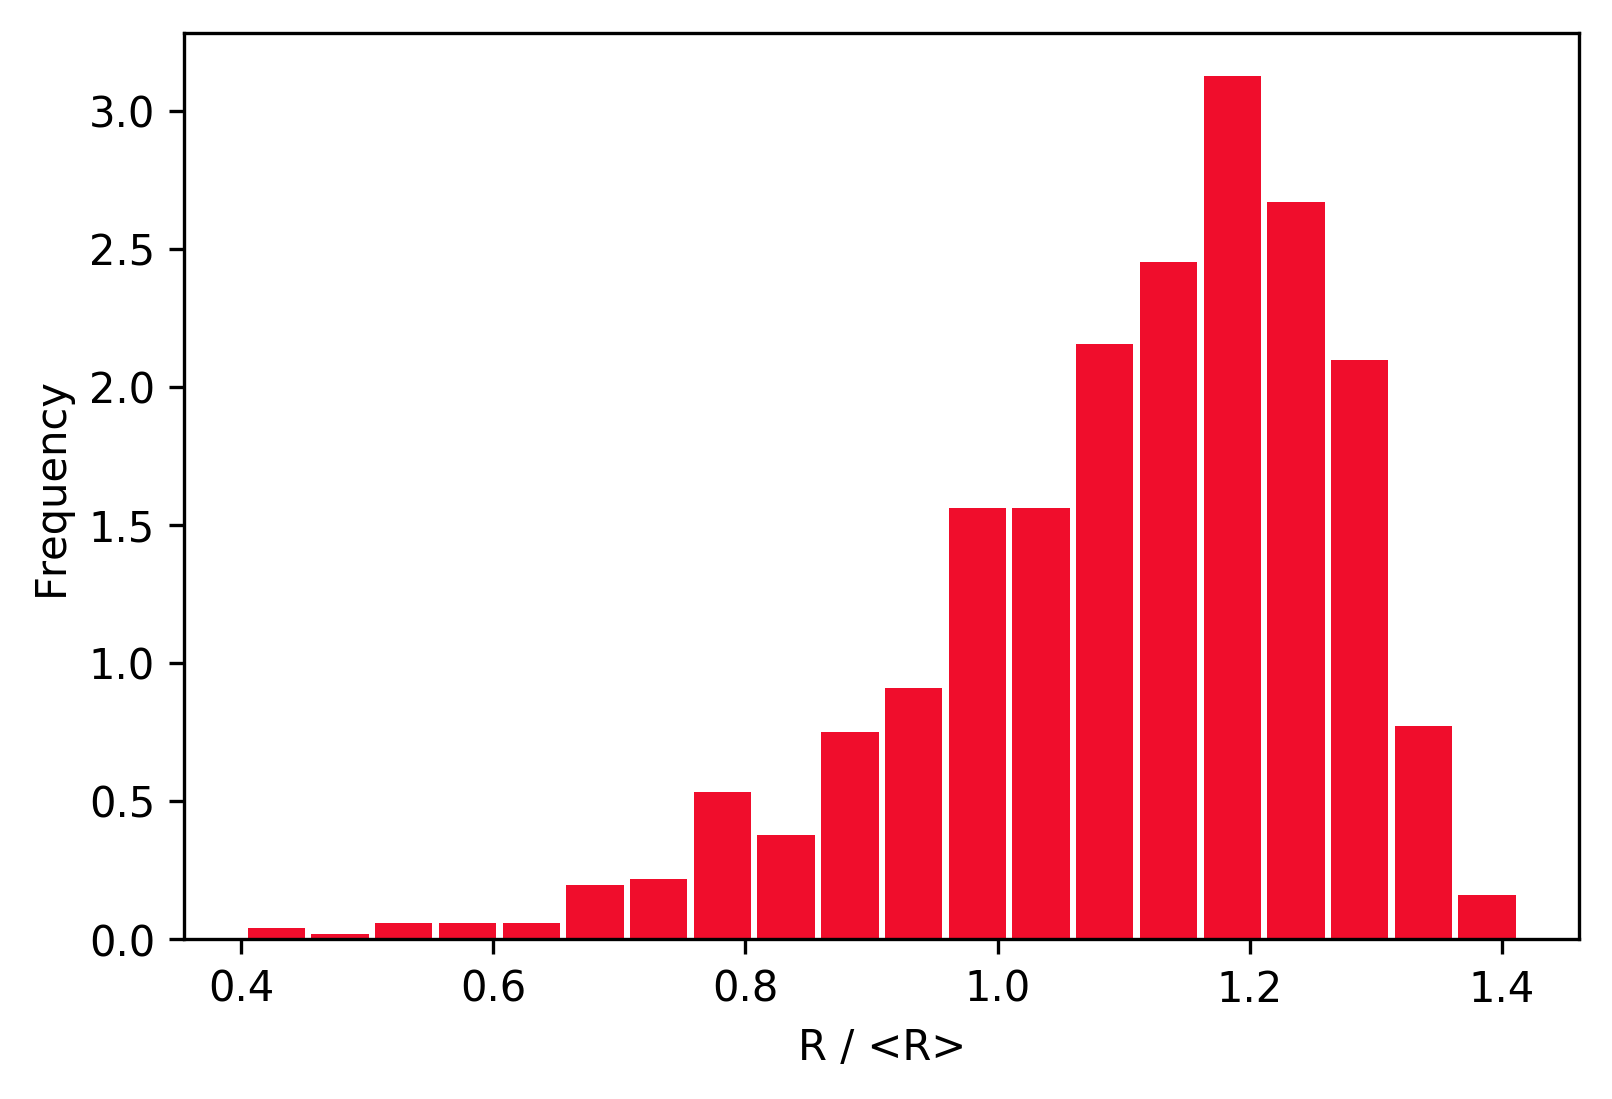

In [3]:
# Load data file
R = np.loadtxt('data/np_radii.txt')

# Plot histograms with 20 bins:
plt.hist(R, rwidth = 0.9, bins=20, density=True)
plt.xlabel('R / <R>')
plt.ylabel('Frequency')

## Likelihood function for the skewed normal distribution

The skewed normal distribution $SN(\alpha, \mu, \sigma)$ has three parameters. For $R \sim SN(\alpha, \mu, \sigma)$ we'll let $f_R(r; \theta)$ be the pdf of the skewed normal distribution.

Recall that the log likelihood function for iid data $r_i, ..., r_n$ is given by:
$$ \ell(\theta) = \sum_{i=1}^n \log f_R(r_i; \theta).$$

Below we'll define a python function that compute the log likelihood function for an input $\theta$. All we need to do is 
* Calculate the pdf values $f_R(r_i; \theta)$ for the given data $r_i$ and the input $\theta$ (We'll use the `scipy.stats.skewnorm.pdf` function to calculate this for the Skew Normal distribution),
* Take the log of these values,
* Add all these values together.
We define this function below.

In [4]:
# We'll need to use the skewnorm pdf to calculate log likelihood
from scipy import stats


# Define log likelihood function for the skewed normal distribution
# - theta is a list with 3 elements: alpha, mu, sigma
# - R = (r_1, r_2, ..., r_n) is the list of data

def log_likelihood(theta, R):
    alpha = theta[0]
    mu = theta[1]
    sigma = theta[2]
    
    # evaluate the skew norm pdf for each element in R
    # using the stats.skewnorm.pdf(data, alpha, mu, sigma) function
    pdf_vals = stats.skewnorm.pdf(R, alpha, mu, sigma)
    
    # calculate log likelihood componentwise
    ret_val = np.sum(np.log(pdf_vals))
    
    # return the log likelihood
    return ret_val

Once defined, we can try passing in example values of parameters alpha, mu and sigma. Try to see if you can find a set of parameters with large log likelihood. Let's stay within the following bounds:

$$ \alpha \in [-7, 0],$$
$$ \mu \in [0, 3], $$
$$ \sigma \in [0.1, 3],$$

How large a likelihood value can you get by trying random points?

In [7]:
# lets calculate some likelihood values for various random guess 
# of the parameters. Remember, we ultimately want the parameters
# with maximum likelihoood value.

alpha = -5
mu = 2
sigma = 0.1

theta = [alpha, mu, sigma]
log_likelihood(theta, R)

-39010.530013336975

## Calling an optimization function

We want to find the optimal value of $\theta$, i.e. the one that maximizes likelihood. There are no closed-form formulas for this ML estimate of the parameters to the skew-normal distribution, so we have to find the optimal values numerically.

We'll use the `scipy.optimize.minimize` function. The three main arguments this function takes are:

1. The function to minimize: This must be the name of a **python function that takes in a single argument** $\theta$ as input.
2. An initial guess of the optimal $\theta$ value
3. Bounds for each variable in $\theta$.

The first point is a bit tricky. We need to specify a python function that takes in a single argument and should be minimized. Instead, we defined a likelihood function above `log_likelihood` that takes in 2 arguments and we wish to maximize this. To quickly define a function that statisfies the requirements of `scipy.optimize.minimize`, we'll use a **lambda expression**, or sometimes called an **anonymous function** in other programming languages.

In [8]:
# we want to use scipy.optimize.minimize function, but 
# that function needs a function that takes the input values (theta)
# only and not the data (R). 
# 
# We also want to negate it since we want to maximize a function.
# To do this, we'll define an anonymous function

LL = lambda t: -1.0*log_likelihood(t, R)

`LL` is a full-fledged python function that we can call. The way we defined it, it takes a single argument
and calculates the negative of the log likelihood function. Here R is the set of data we read in earlier.

In [9]:
## Let's call it:
theta = [-2, 1.2, 1]
LL(theta)

828.8219098464408

Now that we've defined a function of a single argument that we wish to minimize, we can call the `optimize.minimize function`

In [12]:
import scipy.optimize as optimize

theta_guess = [-2, 1.2, 1]
theta_bounds = ((-7, 0), (0, 3), (0.1, 3))

# perform the optimization
res = optimize.minimize(LL, theta_guess, bounds = theta_bounds)

# res is an object with several fields. The one we're interested in is called
# res.x, which contains the optimal theta values.
theta_MLE = res.x

alpha_MLE = theta_MLE[0]
mu_MLE = theta_MLE[1]
sigma_MLE = theta_MLE[2]

print('alpha_MLE = ' + str(alpha_MLE))
print('   mu_MLE = ' + str(mu_MLE))
print('sigma_MLE = ' + str(sigma_MLE))

alpha_MLE = -5.746604767125462
   mu_MLE = 1.3090052467558972
sigma_MLE = 0.2574374913763362


These parameters should have high likelihood, so let's calculate it to check.

In [13]:
max_log_likelihood = log_likelihood(theta_MLE, R)
print('Maximum log-likelihood = ' + str(max_log_likelihood) )

Maximum log-likelihood = 508.52350417982984


We can check how good a fit this is by plotting the histogram versus fitted pdf:

Text(0, 0.5, 'Frequency')

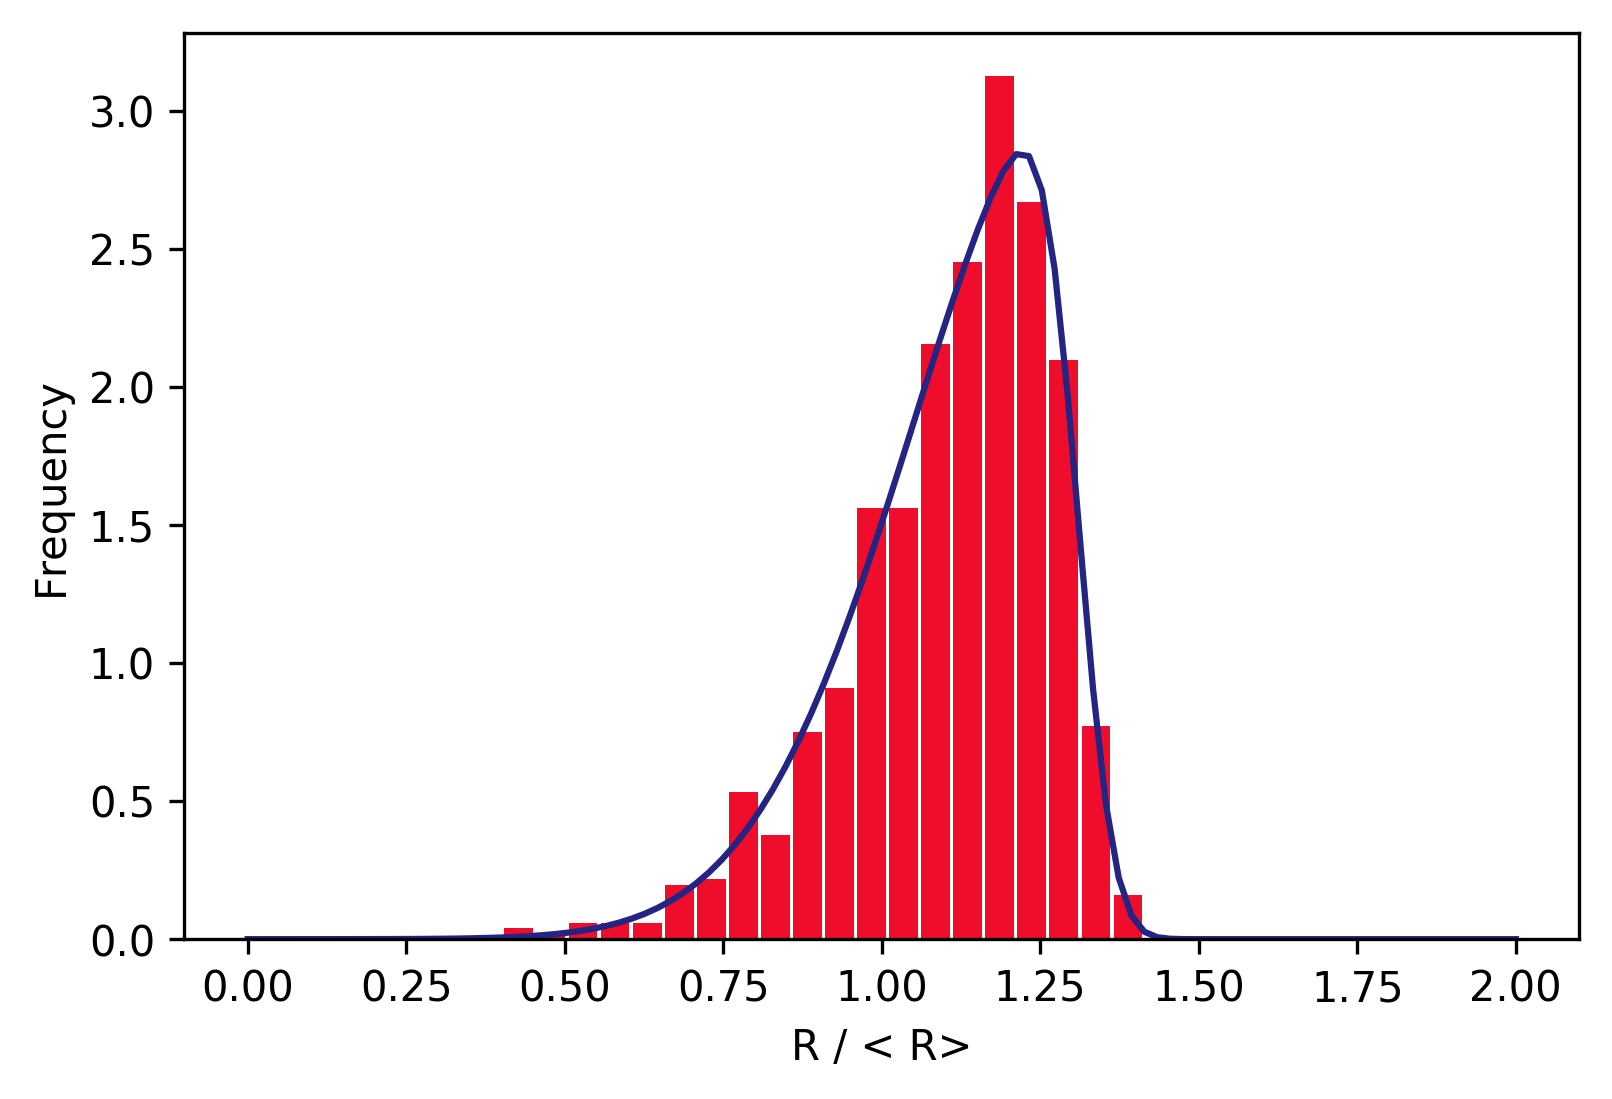

In [14]:
# plot histogram
plt.hist(R, rwidth = 0.9, bins=20, density=True)

# Below: plot the PDF with the MLE parameters

# the space of radii to plot the PDF over
r = np.linspace(0, 2.0, 100)

# evaluate the skew normal pdf at ML estimates
y = stats.skewnorm.pdf(r, alpha_MLE, mu_MLE, sigma_MLE)

# plot pdf
plt.plot(r, y)

# Add labels
plt.xlabel('R / < R>')
plt.ylabel('Frequency')